## This ipynb explored topics of 3 resturants in Las Vegas using LDA

- Wicked Spoon
- Gordon Ramsay BurGR
- Serendipity 3


In [15]:
### Importing all packages
import pandas as pd
import json
from pandas.io.json import json_normalize
import re, string, unicodedata
from wordcloud import WordCloud
%matplotlib inline
import matplotlib.pyplot as plt
import inflect
import nltk
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer 
from hlda.sampler import HierarchicalLDA
import gensim
from pprint import pprint
import spacy
import numpy as np
import pyLDAvis
import pyLDAvis.gensim

### Take a look at the sample data

In [16]:
### Loading the data
def mylines(filename, _from, _to):
    with open(filename, encoding="utf8") as f:
        for i, line in enumerate(f):
            if i >= _from and i <= _to:
                yield json.loads(line)

### Load the data 
#### final_target.csv: filter the top 20 resturants in Las Vegas by review counts with sentiment labels

In [17]:
data = pd.read_csv("final_target.csv")
data.head()

,Unnamed: 0,business_id,cool,date,funny,review_id,stars,text,useful,user_id,prediction_rate,actual_rate
0,0,ujHiaprwCQ5ewziu0Vi9rw,0,2013-12-07 00:14:06,0,f0B9-r14-bLudyu5S7aLhw,1.0,We had dinner at the Bellagio Buffet last nigh...,1,SvMGr_Oih7ivtzmnCL-Tmg,0.0,0
1,1,faPVqws-x-5k2CQKDNtHxw,0,2018-08-04 20:22:15,0,w1I8U4cJ4QGaXA98ImNrbA,5.0,"Service was amazing, Christina was extremely t...",0,rJNdeta-dYO2YcJ3u5JxnA,0.0,1
2,2,Wxxvi3LZbHNIDwJ-ZimtnA,2,2011-07-28 09:06:59,4,Sft1a3j3Hst44CG9gbww0Q,1.0,I am so blown away by this sophisticated & bea...,8,FBxhaS2bPmxwT3I8r3CmkQ,0.0,0
3,3,ujHiaprwCQ5ewziu0Vi9rw,0,2015-12-05 03:28:19,0,A4G1-LTupScgaPmXF1OPMg,4.0,Around $45 for a dinner on a Friday night.\nSn...,0,W2WICriV5Zf03S4ETzEsiQ,1.0,1
4,4,Wxxvi3LZbHNIDwJ-ZimtnA,0,2016-07-14 18:58:35,0,EaXwNVOmpCXwCchMR5TWlQ,3.0,Paid for a view of the strip...Very disappoint...,0,vRSetBkuRMrjZvpW76gXFA,1.0,0


## Resturant 1 (Wicked Spoon)

### Positive Reviews: 

In [18]:
df_res_1 = data[(data["business_id"] == "K7lWdNUhCbcnEvI0NhGewg")]

In [19]:
print ("positive rating but represent negative sentiment:", 
       df_res_1[(df_res_1["actual_rate"] == 1.0) & (df_res_1["prediction_rate"] == 0.0)].shape[0] / df_res_1.shape[0])

print ("negative rating but represent positive sentiment:", 
       df_res_1[(df_res_1["actual_rate"] == 0.0) & (df_res_1["prediction_rate"] == 1.0)].shape[0] / df_res_1.shape[0])

positive rating but represent negative sentiment: 0.1588500072600552
negative rating but represent positive sentiment: 0.2828517496732975


In [20]:
# Turn the data into a list 
df_res_1_p = df_res_1[df_res_1["prediction_rate"] == 1.0]
print ("There are", df_res_1_p.shape[0], "reviews selected")
data_con = df_res_1_p["text"]
data_con_l = data_con.tolist()

There are 5187 reviews selected


### Text Cleaning

In [21]:
# Remove distracting single quotes
data_con_1 = [re.sub("\'", "", sent) for sent in data_con_l]

# Remove punctuation, convert to lowercase and tokenize
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data_con_l))

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
# pprint(trigram_mod[bigram_mod[data_words[0]]])

In [22]:
# Define functions for stopwords, bigrams, trigrams and lemmatization

stop_words = stopwords.words('english')
stop_words.extend(['xxxxxx','Unknown','not applicable','TBD'])

def remove_stopwords(texts):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)

nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# pprint(data_lemmatized[:1])

### Prepare the data for LDA model

In [23]:
vocab = np.asarray([item for sublist in data_lemmatized for item in sublist])
vocab = np.unique(vocab)
print ("Total vocabulary in the corpus: ", len(vocab))

Total vocabulary in the corpus:  9252


In [24]:
vocab = sorted(list(vocab))
vocab_index = {}
for i, w in enumerate(vocab):
    vocab_index[w] = i
    
new_corpus = []
for doc in data_lemmatized:
    new_doc = []
    for word in doc:
        word_idx = vocab_index[word]
        new_doc.append(word_idx)
    new_corpus.append(new_doc)

In [25]:
# Create Dictionary
id2word = gensim.corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
# pprint(corpus[:1])
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

### Build the LDA Model (With Model Tuning)

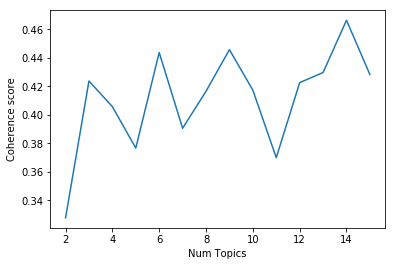

In [26]:
### This step will cost some time
coherence_score = []
for i in range(2,16):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=i, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    coherence_model_lda = gensim.models.coherencemodel.CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_score.append(coherence_lda)

num_topic = [i for i in range(2,16)]

plt.plot(num_topic, coherence_score)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.show()

In [27]:
### Build the model (Choose K = 14 here)

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=14, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.035*"plate" + 0.021*"station" + 0.018*"salad" + 0.018*"meat" + '
  '0.018*"little" + 0.017*"pretty" + 0.014*"look" + 0.013*"section" + '
  '0.012*"cheese" + 0.011*"chocolate"'),
 (1,
  '0.160*"open" + 0.136*"clear" + 0.069*"avoid" + 0.049*"con" + 0.044*"pro" + '
  '0.027*"tomato" + 0.026*"grant" + 0.025*"afternoon" + 0.017*"outside" + '
  '0.011*"safe"'),
 (2,
  '0.059*"food" + 0.037*"good" + 0.032*"go" + 0.021*"come" + 0.021*"buffet" + '
  '0.020*"time" + 0.019*"wicked" + 0.018*"get" + 0.018*"spoon" + '
  '0.018*"place"'),
 (3,
  '0.066*"tea" + 0.059*"attention" + 0.045*"accommodate" + 0.041*"speak" + '
  '0.041*"broth" + 0.040*"lemon" + 0.033*"bottom" + 0.031*"pig" + 0.028*"tend" '
  '+ 0.026*"effort"'),
 (4,
  '0.091*"lamb" + 0.059*"issue" + 0.051*"clam" + 0.050*"late" + 0.042*"carry" '
  '+ 0.040*"cone" + 0.033*"stale" + 0.031*"trendy" + 0.029*"ordinary" + '
  '0.026*"tin"'),
 (5,
  '0.140*"area" + 0.059*"other" + 0.059*"menu" + 0.040*"dollar" + '
  '0.037*"omelette" + 0.

In [28]:
### Visulization
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [29]:
pyLDAvis.display(vis)

### Negative reviews: 

In [30]:
# Turn the data into a list 
df_res_1_n = df_res_1[df_res_1["prediction_rate"] == 0.0]
print ("There are", df_res_1_n.shape[0], "reviews selected")
data_con = df_res_1_n["text"]
data_con_l = data_con.tolist()

There are 1700 reviews selected


### Text cleaning

In [31]:
# Remove distracting single quotes
data_con_1 = [re.sub("\'", "", sent) for sent in data_con_l]

data_words = list(sent_to_words(data_con_l))

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
pprint(trigram_mod[bigram_mod[data_words[0]]])

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)

nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# pprint(data_lemmatized[:1])

['huge',
 'buffett',
 'very',
 'clean',
 'lots',
 'of',
 'options',
 'prompt',
 'staff',
 'we',
 'were',
 'here',
 'for',
 'brunch',
 'and',
 'didn',
 'know',
 'where',
 'to',
 'start',
 'so',
 'much',
 'food',
 'stuck',
 'to',
 'breakfast',
 'sausage',
 'bacon',
 'mac_cheese',
 'and',
 'bunch',
 'of',
 'desserts',
 'eat',
 'there',
 'again',
 'for',
 'sure']


### Prepare the data for the LDA Model

In [32]:
vocab = np.asarray([item for sublist in data_lemmatized for item in sublist])
vocab = np.unique(vocab)
print ("Total vocabulary in the corpus: ", len(vocab))

Total vocabulary in the corpus:  4832


In [33]:
vocab = sorted(list(vocab))
vocab_index = {}
for i, w in enumerate(vocab):
    vocab_index[w] = i
    
new_corpus = []
for doc in data_lemmatized:
    new_doc = []
    for word in doc:
        word_idx = vocab_index[word]
        new_doc.append(word_idx)
    new_corpus.append(new_doc)

In [34]:
# Create Dictionary
id2word = gensim.corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
# pprint(corpus[:1])
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

### Build the LDA model

In [35]:
### Build the model (Choose K = 10 here)

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.062*"refill" + 0.043*"type" + 0.034*"list" + 0.030*"move" + '
  '0.024*"normally" + 0.020*"sushi" + 0.019*"appetize" + '
  '0.018*"high_expectation" + 0.016*"home" + 0.016*"rude"'),
 (1,
  '0.066*"food" + 0.039*"buffet" + 0.035*"good" + 0.030*"go" + 0.023*"come" + '
  '0.023*"great" + 0.020*"place" + 0.020*"would" + 0.018*"selection" + '
  '0.015*"service"'),
 (2,
  '0.046*"horrible" + 0.024*"cure" + 0.022*"period" + 0.014*"anyway" + '
  '0.012*"dumpling" + 0.010*"chit" + 0.008*"swear" + 0.004*"cleaning" + '
  '0.004*"runny" + 0.004*"chat"'),
 (3,
  '0.023*"get" + 0.022*"shrimp" + 0.020*"pay" + 0.017*"night" + 0.017*"table" '
  '+ 0.016*"person" + 0.016*"money" + 0.016*"enough" + 0.014*"last" + '
  '0.013*"bad"'),
 (4,
  '0.110*"line" + 0.096*"wait" + 0.048*"minute" + 0.046*"long" + 0.038*"pay" + '
  '0.032*"seat" + 0.024*"hour" + 0.021*"large" + 0.020*"weekend" + '
  '0.016*"arrive"'),
 (5,
  '0.047*"section" + 0.040*"visit" + 0.037*"use" + 0.022*"fruit" + 0.022*"one" '
  '+

In [36]:
### Visulization
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


## Resturant 2 (Gordon Ramsay BurGR)

### Positive reviews: 

In [37]:
df_res_2 = data[(data["business_id"] == "cYwJA2A6I12KNkm2rtXd5g")]

In [38]:
print ("positive rating but represent negative sentiment:", 
       df_res_2[(df_res_2["actual_rate"] == 1.0) & (df_res_2["prediction_rate"] == 0.0)].shape[0] / df_res_2.shape[0])

print ("negative rating but represent positive sentiment:", 
       df_res_2[(df_res_2["actual_rate"] == 0.0) & (df_res_2["prediction_rate"] == 1.0)].shape[0] / df_res_2.shape[0])

positive rating but represent negative sentiment: 0.18367713004484304
negative rating but represent positive sentiment: 0.21255605381165918


In [39]:
# Turn the data into a list 
df_res_2_p = df_res_2[df_res_2["prediction_rate"] == 1.0]
print ("There are", df_res_2_p.shape[0], "reviews selected")
data_con = df_res_2_p["text"]
data_con_l = data_con.tolist()

There are 4031 reviews selected


### Text Cleaning

In [40]:
# Remove distracting single quotes
data_con_1 = [re.sub("\'", "", sent) for sent in data_con_l]

data_words = list(sent_to_words(data_con_l))

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
pprint(trigram_mod[bigram_mod[data_words[0]]])

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)

nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# pprint(data_lemmatized[:1])

['accessibility',
 'parking',
 'wait',
 'time',
 'star',
 'no',
 'wait',
 'with',
 'reservation',
 'service',
 'waiter',
 'cleanness',
 'ambiance',
 'star',
 'amazing',
 'service',
 'our',
 'waiter',
 'was',
 'the',
 'best',
 'friendly',
 'descriptive',
 'helpful',
 'taste',
 'not',
 'edible',
 'edible',
 'good',
 'average',
 'must',
 'try',
 'stars',
 'best',
 'shake',
 'and',
 'burgers',
 've',
 'ever',
 'had',
 'in',
 'my',
 'life',
 'got',
 'the',
 'oreo',
 'creme_brulee',
 'shake',
 'and',
 'the',
 'farm',
 'burger',
 'highly_recommended',
 'overall',
 'experience',
 'stars',
 'last',
 'words',
 'gordon',
 'ramsay',
 'you',
 'have',
 'new',
 'fan']


### Prepare data for LDA model

In [41]:
vocab = np.asarray([item for sublist in data_lemmatized for item in sublist])
vocab = np.unique(vocab)
print ("Total vocabulary in the corpus: ", len(vocab))

Total vocabulary in the corpus:  7912


In [42]:
vocab = sorted(list(vocab))
vocab_index = {}
for i, w in enumerate(vocab):
    vocab_index[w] = i
    
new_corpus = []
for doc in data_lemmatized:
    new_doc = []
    for word in doc:
        word_idx = vocab_index[word]
        new_doc.append(word_idx)
    new_corpus.append(new_doc)

In [43]:
# Create Dictionary
id2word = gensim.corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
# pprint(corpus[:1])
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

### Model tuning and building

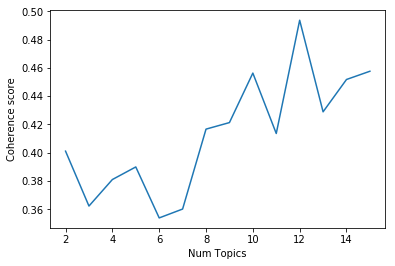

In [44]:
### This step will cost some time
coherence_score = []
for i in range(2,16):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=i, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    coherence_model_lda = gensim.models.coherencemodel.CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_score.append(coherence_lda)

num_topic = [i for i in range(2,16)]

plt.plot(num_topic, coherence_score)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.show()

In [45]:
### Build the model (Choose K = 12 here)

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=12, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.125*"wing" + 0.083*"juicy" + 0.045*"possibly" + 0.037*"affordable" + '
  '0.026*"negative" + 0.025*"vanilla" + 0.023*"similar" + 0.022*"fury_chicken" '
  '+ 0.021*"deliciousness" + 0.020*"forever"'),
 (1,
  '0.044*"food" + 0.041*"wait" + 0.031*"time" + 0.022*"table" + 0.022*"line" + '
  '0.021*"go" + 0.021*"restaurant" + 0.021*"say" + 0.018*"service" + '
  '0.018*"take"'),
 (2,
  '0.040*"drink" + 0.039*"menu" + 0.025*"beer" + 0.020*"cool" + 0.019*"serve" '
  '+ 0.018*"dessert" + 0.016*"fire" + 0.012*"let" + 0.012*"appetizer" + '
  '0.012*"suggest"'),
 (3,
  '0.038*"cheese" + 0.031*"medium" + 0.030*"egg" + 0.029*"perfectly" + '
  '0.022*"popper" + 0.018*"flavor" + 0.017*"cook" + 0.017*"bacon" + '
  '0.017*"bite" + 0.015*"thick"'),
 (4,
  '0.071*"burger" + 0.047*"fry" + 0.043*"good" + 0.026*"order" + 0.022*"get" + '
  '0.021*"come" + 0.019*"place" + 0.019*"try" + 0.017*"great" + 0.015*"also"'),
 (5,
  '0.064*"ever" + 0.031*"excellent" + 0.029*"friendly" + 0.025*"awesome" + '
  

In [46]:
### Visulization
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


### Negative reviews: 

In [47]:
# Turn the data into a list 
df_res_2_n = df_res_2[df_res_2["prediction_rate"] == 0.0]
print ("There are", df_res_2_n.shape[0], "reviews selected")
data_con = df_res_2_n["text"]
data_con_l = data_con.tolist()

There are 1544 reviews selected


### Text cleaning

In [48]:
# Remove distracting single quotes
data_con_1 = [re.sub("\'", "", sent) for sent in data_con_l]

data_words = list(sent_to_words(data_con_l))

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
pprint(trigram_mod[bigram_mod[data_words[0]]])

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)

nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#pprint(data_lemmatized[:1])

['literally',
 'the',
 'best',
 'burger',
 've',
 'had',
 'in',
 'my',
 'entire',
 'life',
 'only',
 'downside',
 'to',
 'eating',
 'here',
 'is',
 'the',
 'super',
 'long',
 'wait',
 'we',
 'went',
 'on',
 'sunday',
 'and',
 'it',
 'was',
 'packed',
 'all',
 'day',
 'waited',
 'minutes',
 'for',
 'table',
 'but',
 'it',
 'was',
 'worth',
 'the',
 'wait',
 'got',
 'the',
 'euro',
 'burger',
 'which',
 'was',
 'gordon_ramsay',
 'burger',
 'with',
 'goats',
 'cheese',
 'arugula',
 'truffle',
 'aioli',
 'and',
 'roasted_tomatoes',
 'so',
 'freakin',
 'good',
 'you',
 'should',
 'eat',
 'here',
 'if',
 'you',
 're',
 'in',
 'the',
 'area',
 'or',
 'you',
 're',
 'missing',
 'out']


### Prepare data for LDA

In [49]:
vocab = np.asarray([item for sublist in data_lemmatized for item in sublist])
vocab = np.unique(vocab)
print ("Total vocabulary in the corpus: ", len(vocab))

Total vocabulary in the corpus:  4460


In [50]:
vocab = sorted(list(vocab))
vocab_index = {}
for i, w in enumerate(vocab):
    vocab_index[w] = i
    
new_corpus = []
for doc in data_lemmatized:
    new_doc = []
    for word in doc:
        word_idx = vocab_index[word]
        new_doc.append(word_idx)
    new_corpus.append(new_doc)

In [51]:
# Create Dictionary
id2word = gensim.corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
# pprint(corpus[:1])
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

### Model tuning and building

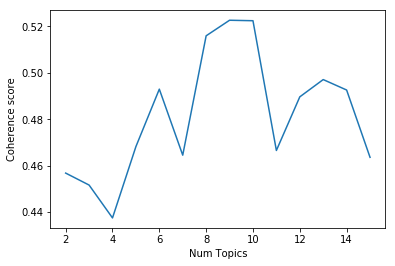

In [52]:
### This step will cost some time
coherence_score = []
for i in range(2,16):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=i, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    coherence_model_lda = gensim.models.coherencemodel.CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_score.append(coherence_lda)

num_topic = [i for i in range(2,16)]

plt.plot(num_topic, coherence_score)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.show()

In [53]:
### Build the model (Choose K = 10 here)

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.069*"disappoint" + 0.036*"surprise" + 0.035*"ok" + 0.032*"send" + '
  '0.031*"due" + 0.030*"excited" + 0.026*"provide" + 0.021*"sugar" + '
  '0.019*"completely" + 0.018*"mom"'),
 (1,
  '0.029*"effort" + 0.028*"basically" + 0.026*"complete" + 0.023*"scream" + '
  '0.022*"tonight" + 0.018*"wow" + 0.015*"sorry" + 0.014*"self" + '
  '0.013*"applebee" + 0.012*"definite"'),
 (2,
  '0.053*"tap" + 0.032*"flat" + 0.022*"ton" + 0.021*"classic" + '
  '0.019*"homemade" + 0.016*"lady" + 0.016*"actual" + 0.015*"eventually" + '
  '0.010*"tend" + 0.008*"terribly"'),
 (3,
  '0.045*"flavor" + 0.021*"maybe" + 0.020*"meat" + 0.018*"spicy" + '
  '0.018*"favorite" + 0.017*"add" + 0.016*"feel" + 0.014*"aioli" + '
  '0.014*"couple" + 0.011*"expectation"'),
 (4,
  '0.041*"minute" + 0.040*"table" + 0.030*"take" + 0.023*"server" + '
  '0.021*"ask" + 0.018*"tell" + 0.017*"food" + 0.016*"would" + 0.015*"order" + '
  '0.014*"wait"'),
 (5,
  '0.033*"receive" + 0.028*"pork" + 0.022*"prompt" + 0.022*"certain

In [54]:
### Visulization
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


## Resturant 3  (Serendipity 3)

In [55]:
df_res_3 = data[(data["business_id"] == "eoHdUeQDNgQ6WYEnP2aiRw")]

In [56]:
print ("positive rating but represent negative sentiment:", 
       df_res_3[(df_res_3["actual_rate"] == 1.0) & (df_res_3["prediction_rate"] == 0.0)].shape[0] / df_res_3.shape[0])

print ("negative rating but represent positive sentiment:", 
       df_res_3[(df_res_3["actual_rate"] == 0.0) & (df_res_3["prediction_rate"] == 1.0)].shape[0] / df_res_3.shape[0])

positive rating but represent negative sentiment: 0.15177234148776836
negative rating but represent positive sentiment: 0.35771342985521715


In [57]:
# Turn the data into a list 
df_res_3_p = df_res_3[df_res_3["prediction_rate"] == 1.0]
print ("There are", df_res_3_p.shape[0], "reviews selected")
data_con = df_res_3_p["text"]
data_con_l = data_con.tolist()

There are 2447 reviews selected


### Text cleaning

In [58]:
# Remove distracting single quotes
data_con_1 = [re.sub("\'", "", sent) for sent in data_con_l]

data_words = list(sent_to_words(data_con_l))

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
pprint(trigram_mod[bigram_mod[data_words[0]]])

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)

nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# print(data_lemmatized[:1])

['the',
 'food',
 'was',
 'amazing',
 'huge',
 'portions',
 'and',
 'all',
 'around',
 'good',
 'we',
 'fed',
 'six',
 'people',
 'for',
 'about',
 'in',
 'vegas',
 'this',
 'is',
 'actually',
 'pretty',
 'good',
 'price',
 'the',
 'reason',
 'didn',
 'give',
 'five',
 'stars',
 'was',
 'because',
 'of',
 'the',
 'customer',
 'service',
 'asked',
 'the',
 'waitress',
 'to',
 'bring',
 'my',
 'daughter',
 'frozen',
 'hot',
 'chocolate',
 'with',
 'candle',
 'in',
 'it',
 'for',
 'her',
 'birthday',
 'saw',
 'that',
 'someone',
 'else',
 'had',
 'this',
 'done',
 'so',
 'that',
 'why',
 'knew',
 'it',
 'was',
 'possible',
 'she',
 'came',
 'to',
 'the',
 'table',
 'with',
 'my',
 'husbands',
 'banana_split',
 'with',
 'candle',
 'in',
 'it',
 'asked',
 'her',
 'where',
 'the',
 'frozen',
 'hot',
 'chocolate',
 'was',
 'and',
 'she',
 'said',
 'oh',
 'well',
 'we',
 'll',
 'just',
 'use',
 'this',
 'purposely',
 'went',
 'and',
 'secretly',
 'asked',
 'them',
 'to',
 'do',
 'this',
 'for'

### Prepare data for LDA

In [59]:
vocab = np.asarray([item for sublist in data_lemmatized for item in sublist])
vocab = np.unique(vocab)
print ("Total vocabulary in the corpus: ", len(vocab))

Total vocabulary in the corpus:  6358


In [60]:
vocab = sorted(list(vocab))
vocab_index = {}
for i, w in enumerate(vocab):
    vocab_index[w] = i
    
new_corpus = []
for doc in data_lemmatized:
    new_doc = []
    for word in doc:
        word_idx = vocab_index[word]
        new_doc.append(word_idx)
    new_corpus.append(new_doc)

In [61]:
# Create Dictionary
id2word = gensim.corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
# pprint(corpus[:1])
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

### Model building and tuning

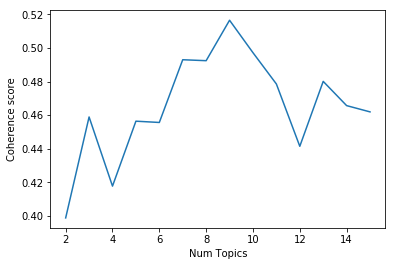

In [62]:
### This step will cost some time
coherence_score = []
for i in range(2,16):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=i, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    coherence_model_lda = gensim.models.coherencemodel.CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_score.append(coherence_lda)

num_topic = [i for i in range(2,16)]

plt.plot(num_topic, coherence_score)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.show()

In [63]:
### Build the model (Choose K = 9 here)

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=9, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.040*"wait" + 0.025*"order" + 0.025*"take" + 0.024*"table" + 0.020*"say" + '
  '0.019*"food" + 0.018*"go" + 0.017*"minute" + 0.016*"service" + 0.015*"sit"'),
 (1,
  '0.043*"huge" + 0.031*"portion" + 0.025*"chicken" + 0.022*"salad" + '
  '0.019*"cheese" + 0.018*"egg" + 0.018*"breakfast" + 0.015*"cake" + '
  '0.015*"meal" + 0.012*"bread"'),
 (2,
  '0.032*"receive" + 0.031*"chance" + 0.027*"town" + 0.026*"sister" + '
  '0.025*"cheeseburger" + 0.024*"pasta" + 0.024*"suck" + 0.023*"mac_cheese" + '
  '0.023*"pre" + 0.016*"crave"'),
 (3,
  '0.107*"plate" + 0.039*"pack" + 0.020*"beer" + 0.019*"smile" + 0.016*"car" + '
  '0.015*"smell" + 0.015*"fix" + 0.014*"dirty" + 0.014*"pump" + '
  '0.012*"number"'),
 (4,
  '0.025*"longer" + 0.022*"other" + 0.022*"salad" + 0.018*"meet" + '
  '0.017*"fall" + 0.017*"asian" + 0.015*"beef" + 0.015*"roll" + 0.014*"steep" '
  '+ 0.014*"texture"'),
 (5,
  '0.041*"waitress" + 0.031*"hostess" + 0.029*"staff" + 0.027*"waiter" + '
  '0.022*"min" + 0.018*"offe

In [64]:
### Visulization
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


### Negative reviews 

In [65]:
# Turn the data into a list 
df_res_3_n = df_res_3[df_res_3["prediction_rate"] == 0.0]
print ("There are", df_res_3_n.shape[0], "reviews selected")
data_con = df_res_3_n["text"]
data_con_l = data_con.tolist()

There are 1559 reviews selected


### Text cleaning

In [66]:
# Remove distracting single quotes
data_con_1 = [re.sub("\'", "", sent) for sent in data_con_l]

data_words = list(sent_to_words(data_con_l))

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
pprint(trigram_mod[bigram_mod[data_words[0]]])

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)

nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# pprint(data_lemmatized[:1])

['don',
 'bother',
 'we',
 'were',
 'greeted',
 'by',
 'some',
 'blonde',
 'hostess',
 'girl',
 'who',
 'was',
 'being',
 'extra',
 'rude',
 'to',
 'everyone',
 'who',
 'had',
 'question',
 'we',
 'asked',
 'how',
 'long',
 'the',
 'wait',
 'was',
 'and',
 'they',
 'said',
 'it',
 'was',
 'to',
 'mins',
 'but',
 'we',
 'were',
 'on',
 'our',
 'way',
 'out',
 'of',
 'vegas',
 'so',
 'we',
 'went',
 'to',
 'the',
 'to',
 'go',
 'side',
 'all',
 'of',
 'us',
 'ordered',
 'the',
 'bacon',
 'cheeseburger',
 'which',
 'was',
 'literally',
 'the',
 'size',
 'of',
 'mcdonald',
 'hamburger',
 'it',
 'came',
 'with',
 'cheese',
 'and',
 'bacon',
 'no',
 'condiments',
 'not',
 'lettuce',
 'or',
 'tomatoes',
 'with',
 'fries',
 'an',
 'extra',
 'large',
 'soda',
 'for',
 'each',
 'we',
 'could',
 'have',
 'gone',
 'to',
 'in',
 'out',
 'and',
 'spent',
 'that',
 'much',
 'on',
 'meals',
 'wanted',
 'rootbeer',
 'as',
 'my',
 'drink',
 'so',
 'they',
 'had',
 'to',
 'give',
 'me',
 'small',
 'becau

### Prepare data for LDA

In [67]:
vocab = np.asarray([item for sublist in data_lemmatized for item in sublist])
vocab = np.unique(vocab)
print ("Total vocabulary in the corpus: ", len(vocab))

Total vocabulary in the corpus:  4669


In [68]:
vocab = sorted(list(vocab))
vocab_index = {}
for i, w in enumerate(vocab):
    vocab_index[w] = i
    
new_corpus = []
for doc in data_lemmatized:
    new_doc = []
    for word in doc:
        word_idx = vocab_index[word]
        new_doc.append(word_idx)
    new_corpus.append(new_doc)

In [69]:
# Create Dictionary
id2word = gensim.corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
# pprint(corpus[:1])
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

### Model building and tuning

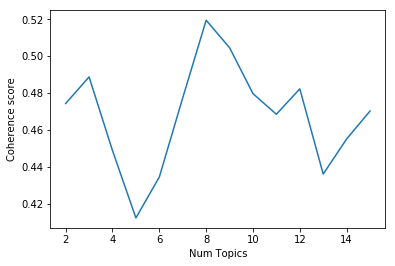

In [70]:
### This step will cost some time
coherence_score = []
for i in range(2,16):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=i, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    coherence_model_lda = gensim.models.coherencemodel.CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_score.append(coherence_lda)

num_topic = [i for i in range(2,16)]

plt.plot(num_topic, coherence_score)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.show()

In [71]:
### Build the model (Choose K = 8 here)

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.033*"instead" + 0.022*"lady" + 0.015*"miss" + 0.015*"grab" + '
  '0.014*"crave" + 0.014*"build" + 0.014*"dirty" + 0.014*"poor" + '
  '0.013*"obviously" + 0.013*"pleasant"'),
 (1,
  '0.088*"chocolate" + 0.082*"hot" + 0.034*"freeze" + 0.030*"frozen" + '
  '0.027*"try" + 0.017*"serendipity" + 0.016*"really" + 0.015*"go" + '
  '0.013*"good" + 0.013*"taste"'),
 (2,
  '0.029*"guy" + 0.026*"fresh" + 0.019*"around" + 0.014*"bland" + '
  '0.014*"colorful" + 0.014*"girly" + 0.013*"pretzel" + 0.013*"starbuck" + '
  '0.011*"handle" + 0.010*"snack"'),
 (3,
  '0.032*"customer" + 0.028*"tell" + 0.027*"hostess" + 0.023*"mean" + '
  '0.023*"close" + 0.021*"rude" + 0.019*"water" + 0.017*"manager" + '
  '0.017*"later" + 0.012*"pm"'),
 (4,
  '0.040*"birthday" + 0.022*"world" + 0.021*"cake" + 0.021*"pack" + '
  '0.016*"strawberry" + 0.013*"crowd" + 0.012*"white" + 0.012*"honest" + '
  '0.010*"willing" + 0.010*"shot"'),
 (5,
  '0.033*"wait" + 0.031*"order" + 0.029*"go" + 0.027*"come" + 0.024*"get"

In [72]:
### Visulization
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))
